In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Import train and test data

In [3]:
train = pd.read_csv("train.csv")
test =pd.read_csv("test.csv")

Missing values in Train set

In [4]:
train.isna().sum(), test.isna().sum()

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64)

Make "Sex" column binary by changing female to 1 and male to 0

In [6]:
for df in [train, test]:
  df["Sex"]=df["Sex"].map({"female": 1, "male": 0}).astype(int)


Explore the data with a Corelation-Matrix

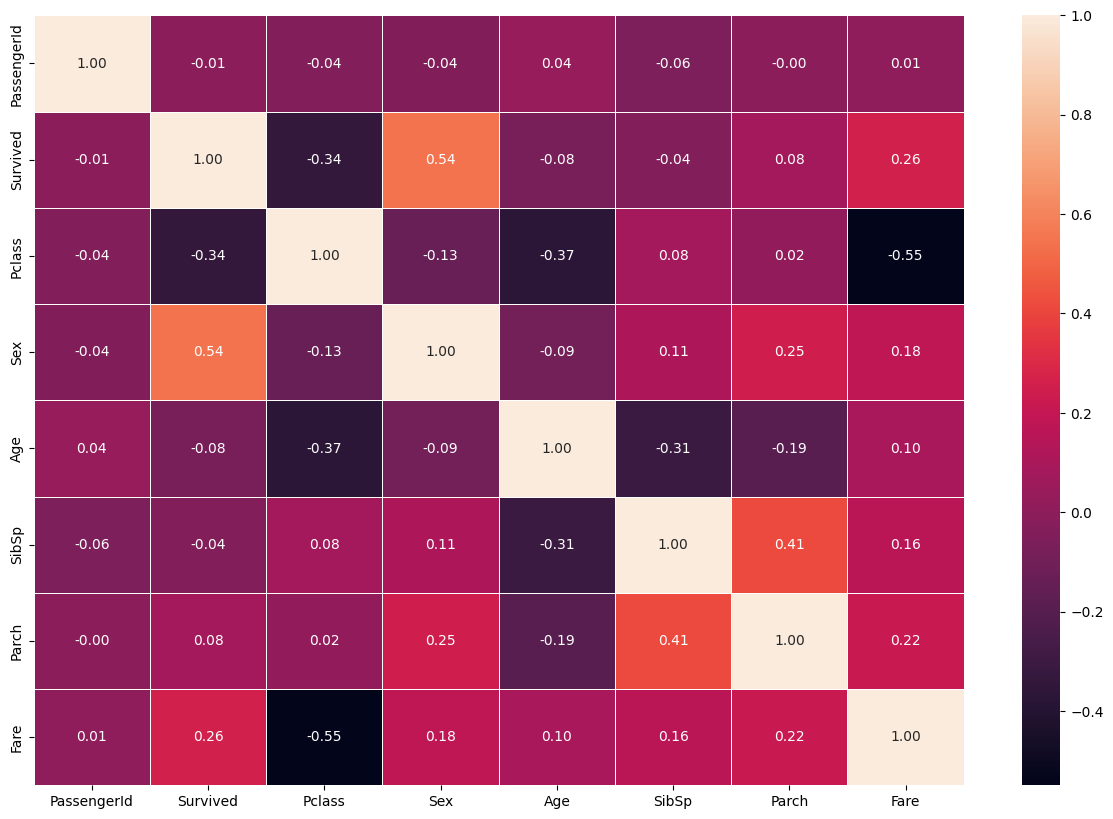

In [7]:
corrM=train.drop(["Name","Cabin", "Ticket", "Embarked"], axis=1).corr()
fig_ax=plt.subplots(figsize=(15,10))
ax=sns.heatmap(corrM,
               annot=True,
               linewidths=0.5,
               fmt=".2f",
               )

## FILL MISSING VALUES

Fill missing "Age" values with median of the relatedt "Pclass" as "Pclass" is the highest correlatedt value to "Age" (-0.37). Seperatly for both test and train data

In [9]:
for df in [train, test]:
  median_ages = df.groupby("Pclass")['Age'].transform('median')
  df['Age'] = df['Age'].fillna(median_ages)

Fill the 2 missing "Embarked" values in the train data with the most comon value for this data which is "S"


In [10]:
train["Embarked"].fillna("S", inplace=True)

<ipython-input-10-7a1a2de98e02>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Embarked"].fillna("S", inplace=True)


Fill the one missing "Fare" value in the test data with the median of the related "Pclass" as "Pclass" is the highest coreelatedt value to "Fare" (-0.55)

In [11]:
median_fares = train.groupby("Pclass")['Fare'].transform('median')
test['Fare'] = test['Fare'].fillna(median_fares)

## Feature Engineering


New "CabinMissing" column from "Cabin". Make binary 1 for True and 0 for False

In [12]:
for df in [train, test]:
  df["CabinMissing"]=df["Cabin"].isna()
  df["CabinMissing"]=df["CabinMissing"].map({True: 1, False: 0}).astype(int)

New "Deck" column from first letter of data in "Cabin" Column. "U" for missing values

In [14]:
for df in [train, test]:
  df["Deck"] = df["Cabin"].str[0].fillna("U")

New "Title" column from title in "Name" column. Group rare titles (e.g. "Don", "Dr", "Lady") into "Rare". Fill the one missing value of "Title" in test data with "Miss" as guessed form passanger name.

In [16]:
for df in [train, test]:
  df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [17]:
for df in [train, test]:
  df["Title"]=df["Title"].replace(["Capt", "Col", "Countess", "Don", "Dr", "Jonkheer", "Lady", "Major", "Rev", "Sir"], "Rare")
  df['Title'] = df['Title'].replace('Mlle', 'Miss')
  df['Title'] = df['Title'].replace('Ms', 'Miss')
  df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [18]:
for df in [train, test]:
  df["Title"] = df["Title"].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

In [26]:
test["Title"].fillna(2, inplace=True)

<ipython-input-26-3eed2a74025d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["Title"].fillna(2, inplace=True)


New "IsAlone" column from FamilySize calculated by adding "Parch", "Sibsp", plus one (him/herself). 1 for is alone and 0 for is not alone

In [27]:
for df in [train, test]:
  df["FamilySize"]=df["SibSp"]+df["Parch"]+1
  df["IsAlone"]=0
  df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

New "FamilySize" column

In [28]:
for df in [train, test]:
  df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

Transform "Age" column by grouping ages and giving it accending numbers staring from 0.

In [29]:
train['Age'] = train['Age'].astype(int)
train["AgeBand"] = pd.cut(train["Age"], 5)
train[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean().sort_values(by="AgeBand",ascending=True)

<ipython-input-29-6dfd1ec5d4a8>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean().sort_values(by="AgeBand",ascending=True)


,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [30]:
for df in [train, test]:
  df.loc[df["Age"] <= 16, "Age"]=0
  df.loc[(df["Age"]> 16)& (df["Age"]<32), "Age"]=1
  df.loc[(df["Age"]> 31)& (df["Age"]<48), "Age"]=2
  df.loc[(df["Age"]> 47)& (df["Age"]<64), "Age"]=3
  df.loc[df["Age"]> 63, "Age"]=4
  df['Age'] = df['Age'].astype(int)

In [31]:
train.drop("AgeBand", axis=1, inplace=True)

Transform "Fare" column by grouping fares and giving it accending numbers staring from 0.

In [33]:
train["FareBand"] = pd.qcut(train["Fare"], 4)
train[["FareBand", "Survived"]].groupby(["FareBand"], as_index=False).mean().sort_values(by="FareBand",ascending=True)

<ipython-input-33-3eb20e6086c4>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[["FareBand", "Survived"]].groupby(["FareBand"], as_index=False).mean().sort_values(by="FareBand",ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [34]:
for df in [train, test]:
  df.loc[df["Fare"] <= 7.91, "Fare"]=0
  df.loc[(df["Fare"]> 7.91)& (df["Fare"]<14.454), "Fare"]=1
  df.loc[(df["Fare"]> 14.453)& (df["Fare"]<31.0), "Fare"]=2
  df.loc[df["Fare"]> 30.9, "Fare"]=3
  df['Fare'] = df['Fare'].astype(int)

In [35]:
train.drop(['FareBand'], axis=1, inplace=True)

## Encodeing



Drop columns before 1 hot encoding.
*   "PassengerId" "Ticket": enteirly droped as it is not needed for the predicitons
*   "Name": was converted int the "Title" column
*   "SibSp" and "Parch": was used for "IsAlone" and "FamilySize" column
*   "Cabin": was used for "Deck" column



In [37]:
for df in [train, test]:
  df.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin"], axis=1, inplace=True)

Encode "Title", "Embarked" and "Deck" with OneHotEncoder. As all other categorigal features ("Sex", "IsAlone", "FamilySize", "Fare", "CabinMissing" etc.) is already in the needed format.

In [43]:
one_hot_columns = ["Title", "Embarked", "Deck"]
encoder = OneHotEncoder(dtype=int, sparse_output=False)

In [45]:
encoded_features = encoder.fit_transform(train[one_hot_columns])
train_3 = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(one_hot_columns))
train_3.index = train.index

In [46]:
encoded_features = encoder.fit_transform(test[one_hot_columns])
test_3 = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(one_hot_columns))
test_3.index = test.index

Dataframe cleaning after encoding:
*   Add "Deck_T" (all zero) column to test data
*   Make "Age" column header equal between train and test data


In [47]:
train_f = pd.concat([train, train_3], axis=1)
test_f = pd.concat([test, test_3], axis=1)

In [49]:
for df in [train_f, test_f]:
  df.drop(["Embarked", "Title", "Deck"], axis=1, inplace=True)

In [52]:
test_f.rename(columns = {'Title_1.0':'Title_1',
                         'Title_2.0':'Title_2',
                          'Title_3.0':'Title_3',
                         'Title_4.0':'Title_4',
                         'Title_5.0':'Title_5'}, inplace = True)

In [53]:
test_f["Deck_T"]=0
test_f = test_f[['Pclass',
 'Sex',
 'Age',
 'Fare',
 'CabinMissing',
 'FamilySize',
 'IsAlone',
 'Title_1',
 'Title_2',
 'Title_3',
 'Title_4',
 'Title_5',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'Deck_U']]

In [54]:
train_f.shape, test_f.shape

((891, 25), (418, 24))

##Define X and y and make train test split on train data

In [55]:
X = train_f.drop(["Survived"], axis=1)
y = train["Survived"]


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

##Train Model
try different models. See their inital score and try to improve by parameter tuning afterwars work with the best models by gridsearch parameter tuning to improve model even more

In [57]:
from sklearn import svm
np.random.seed(42)

svm_m = svm.SVC().fit(X_train, y_train)
svm_score=svm_m.score(X_test, y_test)
svm_score


0.8100558659217877

In [58]:
np.random.seed(42)

svr_m = svm.SVR().fit(X_train, y_train)
svr_score=svr_m.score(X_test, y_test)
svr_score

0.3277666593297591

In [59]:
from sklearn.linear_model import SGDClassifier

np.random.seed(42)

sgd_m = SGDClassifier().fit(X_train, y_train)
sgd_score=sgd_m.score(X_test, y_test)
sgd_score

0.7486033519553073

In [60]:
from sklearn.naive_bayes import GaussianNB

np.random.seed(42)

gau_m = GaussianNB().fit(X_train, y_train)
gau_score=gau_m.score(X_test, y_test)
gau_score

0.7206703910614525

In [ ]:
from sklearn.cross_decomposition import PLSRegression
np.random.seed(42)

pls_m = PLSRegression().fit(X_train, y_train)
pls_score=gau_m.score(X_test, y_test)
pls_score

0.7318435754189944

In [ ]:
from sklearn.naive_bayes import ComplementNB

np.random.seed(42)

com_m = ComplementNB().fit(X_train, y_train)
com_score=com_m.score(X_test, y_test)
com_score

0.7430167597765364

In [ ]:
from sklearn.tree import DecisionTreeClassifier
np.random.seed(42)

dt_m = DecisionTreeClassifier().fit(X_train, y_train)
dt_score=dt_m.score(X_test, y_test)
dt_score

0.7932960893854749

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(42)

gbc_m = GradientBoostingClassifier().fit(X_train, y_train)
gbc_score=gbc_m.score(X_test, y_test)
gbc_score

0.8435754189944135

Tune Random Foresst Clasifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

clf = RandomForestClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8156424581005587

In [ ]:
np.random.seed(42)
for n in ["gini", "entropy", "log_loss"]:

  clf = RandomForestClassifier(criterion=n).fit(X_train, y_train)
  print(f" for {n} criterion = {clf.score(X_test, y_test)}")

 for gini criterion = 0.8491620111731844
 for entropy criterion = 0.8435754189944135
 for log_loss criterion = 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in [1, 3, 5, 7, 9, 12, 15, 23, 29, 50]:

  clf = RandomForestClassifier(max_depth=n).fit(X_train, y_train)
  print(f" for {n} max_depth = {clf.score(X_test, y_test)}")

 for 1 max_depth = 0.7988826815642458
 for 3 max_depth = 0.8268156424581006
 for 5 max_depth = 0.8435754189944135
 for 7 max_depth = 0.8379888268156425
 for 9 max_depth = 0.8547486033519553
 for 12 max_depth = 0.8491620111731844
 for 15 max_depth = 0.8379888268156425
 for 23 max_depth = 0.8379888268156425
 for 29 max_depth = 0.8435754189944135
 for 50 max_depth = 0.8379888268156425


In [ ]:
np.random.seed(42)
for n in [ 3, 5, 7, 9, 11, 16, 20]:

  clf = RandomForestClassifier(min_samples_split=n).fit(X_train, y_train)
  print(f" for {n} min_samples_split= {clf.score(X_test, y_test)}")

 for 3 min_samples_split= 0.8324022346368715
 for 5 min_samples_split= 0.8379888268156425
 for 7 min_samples_split= 0.8659217877094972
 for 9 min_samples_split= 0.8659217877094972
 for 11 min_samples_split= 0.8491620111731844
 for 16 min_samples_split= 0.8603351955307262
 for 20 min_samples_split= 0.8324022346368715


In [ ]:
np.random.seed(42)
for n in [1, 2, 3, 4, 5, 7, 9,11]:

  clf = RandomForestClassifier(min_samples_leaf=n).fit(X_train, y_train)
  print(f" for {n} min_samples_leaft= {clf.score(X_test, y_test)}")

 for 1 min_samples_leaft= 0.8491620111731844
 for 2 min_samples_leaft= 0.8547486033519553
 for 3 min_samples_leaft= 0.8547486033519553
 for 4 min_samples_leaft= 0.8491620111731844
 for 5 min_samples_leaft= 0.8435754189944135
 for 7 min_samples_leaft= 0.8547486033519553
 for 9 min_samples_leaft= 0.8324022346368715
 for 11 min_samples_leaft= 0.8379888268156425


In [ ]:
np.random.seed(42)
for n in ["sqrt", "log2", None]:

  clf = RandomForestClassifier(max_features=n).fit(X_train, y_train)
  print(f" for {n} max_features= {clf.score(X_test, y_test)}")

 for sqrt max_features= 0.8491620111731844
 for log2 max_features= 0.8435754189944135
 for None max_features= 0.8324022346368715


In [ ]:

np.random.seed(42)

clf = RandomForestClassifier(criterion="gini", max_depth=9, min_samples_split= 9, min_samples_leaf= 7, max_features="sqrt").fit(X_train, y_train)
clf.score(X_test, y_test)

0.8379888268156425

In [ ]:
grid = {"criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [5, 9, 12],
        "min_samples_leaf": [2, 3, 5, 7 ],
        "min_samples_split": [7, 9, 11, 16],
        "max_features": ["sqrt", "log2", None],

        }

clf = RandomForestClassifier().fit(X_train, y_train)

gs_clf = GridSearchCV(estimator = clf,
                            param_grid =grid,
                            cv=5,
                            verbose=2)

gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=7; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=9; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=9; total time=   0.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=9; total time=   0.2s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 9, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [2, 3, 5, 7],
                         'min_samples_split': [7, 9, 11, 16]},
             verbose=2)

In [ ]:
np.random.seed(42)
gs_clf.score(X_test, y_test)

0.8659217877094972

In [ ]:
gs_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

##Tune Gradient Boosting Classifier

In [ ]:
np.random.seed(42)
for n in ["log_loss", "exponential"]:
  gbc_m = GradientBoostingClassifier(loss=n).fit(X_train, y_train)
  print(f" for {n} loss= {gbc_m.score(X_test, y_test)}")


 for log_loss loss= 0.8435754189944135
 for exponential loss= 0.8603351955307262


In [ ]:
np.random.seed(42)
for n in [0.1, 0.2, 0.5, 0.9]:
  gbc_m = GradientBoostingClassifier(learning_rate=n).fit(X_train, y_train)
  print(f" for {n} learning_rate= {gbc_m.score(X_test, y_test)}")

 for 0.1 learning_rate= 0.8435754189944135
 for 0.2 learning_rate= 0.8379888268156425
 for 0.5 learning_rate= 0.8268156424581006
 for 0.9 learning_rate= 0.7988826815642458


In [ ]:
np.random.seed(42)
for n in [100, 150, 200, 250, 500]:
  gbc_m = GradientBoostingClassifier(n_estimators=n).fit(X_train, y_train)
  print(f" for {n} n_estimators= {gbc_m.score(X_test, y_test)}")

 for 100 n_estimators= 0.8435754189944135
 for 150 n_estimators= 0.8435754189944135
 for 200 n_estimators= 0.8491620111731844
 for 250 n_estimators= 0.8156424581005587
 for 500 n_estimators= 0.8044692737430168


In [ ]:
np.random.seed(42)
for n in [2, 4, 7, 10, 15, 25, 50, 65]:
  gbc_m = GradientBoostingClassifier(min_samples_split=n).fit(X_train, y_train)
  print(f" for {n} min_samples_split= {gbc_m.score(X_test, y_test)}")

 for 2 min_samples_split= 0.8435754189944135
 for 4 min_samples_split= 0.8435754189944135
 for 7 min_samples_split= 0.8435754189944135
 for 10 min_samples_split= 0.8435754189944135
 for 15 min_samples_split= 0.8379888268156425
 for 25 min_samples_split= 0.8435754189944135
 for 50 min_samples_split= 0.8435754189944135
 for 65 min_samples_split= 0.8379888268156425


In [ ]:
np.random.seed(42)
for n in [2, 4, 7, 10, 15, 25, 50, 65]:
  gbc_m = GradientBoostingClassifier(min_samples_leaf=n).fit(X_train, y_train)
  print(f" for {n} min_samples_leaf= {gbc_m.score(X_test, y_test)}")

 for 2 min_samples_leaf= 0.8547486033519553
 for 4 min_samples_leaf= 0.8547486033519553
 for 7 min_samples_leaf= 0.8547486033519553
 for 10 min_samples_leaf= 0.8268156424581006
 for 15 min_samples_leaf= 0.8547486033519553
 for 25 min_samples_leaf= 0.8379888268156425
 for 50 min_samples_leaf= 0.8491620111731844
 for 65 min_samples_leaf= 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in [1, 3, 5, 9, 15, 25]:
  gbc_m = GradientBoostingClassifier(max_depth=n).fit(X_train, y_train)
  print(f" for {n} max_depth= {gbc_m.score(X_test, y_test)}")

 for 1 max_depth= 0.8491620111731844
 for 3 max_depth= 0.8435754189944135
 for 5 max_depth= 0.7877094972067039
 for 9 max_depth= 0.7877094972067039
 for 15 max_depth= 0.776536312849162
 for 25 max_depth= 0.7877094972067039


In [ ]:
np.random.seed(42)
for n in ["sqrt", "log2"]:
  gbc_m = GradientBoostingClassifier(max_features=n).fit(X_train, y_train)
  print(f" for {n} max_features= {gbc_m.score(X_test, y_test)}")

 for sqrt max_features= 0.8379888268156425
 for log2 max_features= 0.8212290502793296


In [ ]:
np.random.seed(42)
grid = {"loss": ["log_loss", "exponential"],
        "learning_rate": [0.1, 0.2, 0.3],
        "min_samples_leaf": [7, 15, 50],
        "max_depth": ["sqrt", "log2", None]
        }

gbc_m = GradientBoostingClassifier().fit(X_train, y_train)

gs_gbc_m = GridSearchCV(estimator = gbc_m,
                            param_grid =grid,
                            cv=5,
                            verbose=2)

gs_gbc_m.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=7; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=7; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=7; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=7; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=7; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=15; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=15; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=15; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=sqrt, min_samples_leaf=15; total time=   0.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': ['sqrt', 'log2', None],
                         'min_samples_leaf': [7, 15, 50]},
             verbose=2)

In [ ]:
np.random.seed(42)
gs_gbc_m.score(X_test, y_test)

0.8379888268156425

## Tune svm

In [ ]:
np.random.seed(42)
for n in ["linear", "poly", "rbf", "sigmoid", "rbf"]:
  svm_m = svm.SVC(kernel=n).fit(X_train, y_train)
  print(f" for {n} kernel= {svm_m.score(X_test, y_test)}")


 for linear kernel= 0.8379888268156425
 for poly kernel= 0.8547486033519553
 for rbf kernel= 0.8491620111731844
 for sigmoid kernel= 0.6536312849162011
 for rbf kernel= 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in [1, 2, 3, 4, 5]:
  svm_m = svm.SVC(degree=n).fit(X_train, y_train)
  print(f" for {n} degree= {svm_m.score(X_test, y_test)}")

 for 1 degree= 0.8491620111731844
 for 2 degree= 0.8491620111731844
 for 3 degree= 0.8491620111731844
 for 4 degree= 0.8491620111731844
 for 5 degree= 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in [1, 5, 10, 15, 25,100]:
  svm_m = svm.SVC(C=n).fit(X_train, y_train)
  print(f" for {n} C= {svm_m.score(X_test, y_test)}")

 for 1 C= 0.8491620111731844
 for 5 C= 0.8379888268156425
 for 10 C= 0.8547486033519553
 for 15 C= 0.8547486033519553
 for 25 C= 0.8491620111731844
 for 100 C= 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in ["scale", "auto"]:
  svm_m = svm.SVC(gamma=n).fit(X_train, y_train)
  print(f" for {n} gamma= {svm_m.score(X_test, y_test)}")

 for scale gamma= 0.8491620111731844
 for auto gamma= 0.8491620111731844


In [ ]:
np.random.seed(42)
for n in ["ovo", "ovr"]:
  svm_m = svm.SVC(decision_function_shape=n).fit(X_train, y_train)
  print(f" for {n} decision_function_shape= {svm_m.score(X_test, y_test)}")

 for ovo decision_function_shape= 0.8491620111731844
 for ovr decision_function_shape= 0.8491620111731844


In [ ]:
grid = {"kernel": ["linear", "poly", "rbf"],
        "C": [1, 10, 15, 25],
        }

svm_m = svm.SVC().fit(X_train, y_train)

gs_svm_m = GridSearchCV(estimator = clf,
                            param_grid =grid,
                            cv=5,
                            verbose=2)

gs_svm_m.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 15, 25],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=2)

In [ ]:
np.random.seed(42)
gs_svm_m.score(X_test, y_test)

0.8491620111731844

## Make predictions and export them as .csv file to upload as submision

In [ ]:
y_preds=gs_svm_m.predict(test_f)
y_preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
result = pd.DataFrame({
"PassengerId": pd.read_csv("test.csv")["PassengerId"],
 "Survived": y_preds
})

In [ ]:
result.to_csv('result_8.csv', index=False)